# Uncertainty quantification for spline basis functions for 1-D data

Basis splines are famously versatile and can express diverse patterns in data. They provide additional flexibility without adding too many degrees of freedom.

In [1]:
import autograd.numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from ml_uncertainty.model_inference import ParametricModelInference
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import pandas as pd

## Synthetic data

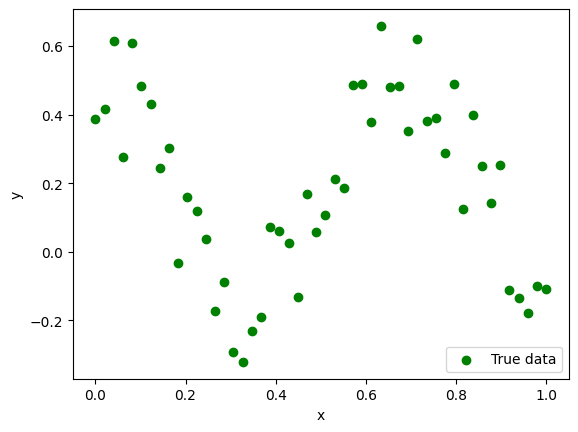

In [2]:
# Generate synthetic data using a spline model.
# Here, we generate a very basic dataset with an underlying distribution of a natural cubic spline with 3 knots. 

# X variable.
X_true = np.linspace(0, 1, 50).reshape(-1, 1) # To be consistent with the Sklearn and ML uncertainty notation

# B-Spline with degree 3. 
spline_true = SplineTransformer(n_knots=4, degree=3, include_bias=True) 

# We also fit the spline to the X data as it needs to learn where the knots are to be placed, etc.
spline_true.fit(X_true)

# True_params in the experiment. Here, shape of true_params must match the output of the spline transform.
# We know apriori that for natural cubic spline with K knots, the params are K. With intercept absent, it is K-1.
# But, to double check, we can also check the dimensions of the output of the spline fit. 
true_params = np.array([-1.0, 1.0, -1.0, 1.0, -1.0, 2.0])

# Output generated from the spline model.
y_spline_true = np.matmul(spline_true.transform(X_true), true_params.reshape(-1, 1))[:, 0]

# Add a random Gaussian noise of standard deviation 0.4. 
y_true = y_spline_true + np.random.random(X_true.shape[0]) * 0.4

# Plot the synthetic data.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(X_true[:, 0], y_true, label="True data", color="green")
ax.legend(loc="lower right")

In [3]:
# To reiterate, this is the data we have i.e., synthetic data / true data. So, we know the parameters and the 
# underlying function that generated the data.
# Let's assume, however, that we didn't know the underlying function and only had access to this data. 
# We wish to build a model for this data and know the uncertainties associated with it. 
# We can leverage LinearRegression class of scikit-learn using this basis expansion.

# Building the model.
# We know that this cannot be modelled using a simple linear model as the shapes are quite complex.  
# To model something as complex as this, we can use the spline basis expansion. 
# NOTE: We set include_bias to False so that we can absorb it later into the intercept of the
# LinearRegression step. This way, we avoid double-counting the bias term.
spline = SplineTransformer(n_knots=4, degree=3, include_bias=False)

# This will output the spline basis. Check out the shape using the following. 
# spline(X_expt).shape

# Now, the next step is to perform a regression to link this with the y data. To do this, we will use the linear regression model.
linear_model = LinearRegression()

# Now, we will combine these two together to make a pipeline. 
pipeline = make_pipeline(
    spline,
    linear_model
)


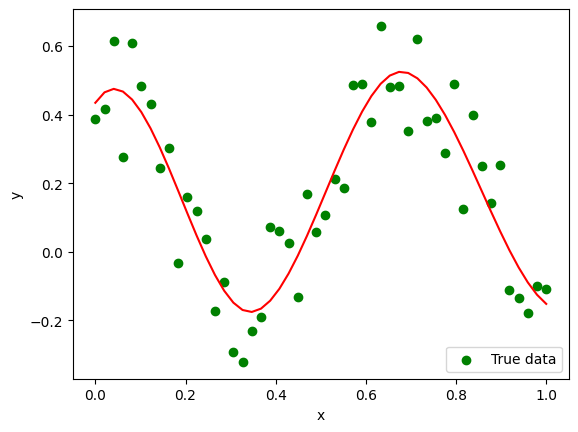

In [4]:
# Next, we fit the function to the data.
# NOTE: Even though the "fit" method is applied to the spline, it only figures out the location of the knots, etc., so that the basis is well-specified
# for the domain.
pipeline.fit(X_true, y_true)

# Predict based on this pipeline.
y_pred = pipeline.predict(X_true)

# Plot the figures together.
ax.plot(X_true[:, 0], y_pred, linestyle="-", color="red", label="Predicted data")
fig

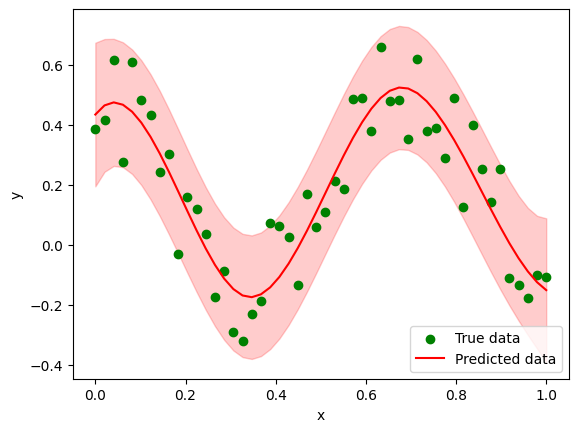

In [5]:
# Now, we can predict the uncertainty in parameters and prediction intervals using the standard ML uncertainty workflow.

inf = ParametricModelInference()
inf.set_up_model_inference(X_train=pipeline[0].transform(X_true), 
                               y_train=y_true, estimator=linear_model)

# Get prediction intervals on the features.
df_feature_imp = inf.get_parameter_errors()

# Getting prediction intervals for X_expt values.
df_int = inf.get_intervals(pipeline[0].transform(X_true))

# Add error bars from the package.
ax.fill_between(
    X_true[:, 0],
    df_int["lower_bound"],
    df_int["upper_bound"],
    color="red",
    alpha=0.2,
    zorder=0,
)
ax.legend(loc="lower right")
fig

In [9]:
# NOTE: For cubic splines, one can use the methods provided here. B-Splines are more commonly available than natural splines.
# https://www.kirenz.com/blog/posts/2021-12-06-regression-splines-in-python/